In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Data import and exploration

In [64]:
data = pd.read_csv("data\\train.csv")

In [48]:
test = pd.read_csv("data\\test.csv")

In [4]:
data.isnull().sum()

# The data doesn't have in null values

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [5]:
data.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.53,Very Good,G,SI1,63.4,54.0,5.09,5.13,3.24,7.057
1,1,0.41,Ideal,D,SI1,63.0,56.0,4.80,4.75,3.01,6.824
2,2,0.32,Ideal,I,VS2,61.6,56.0,4.37,4.39,2.70,6.107
3,3,0.31,Ideal,H,VVS2,61.2,56.0,4.34,4.37,2.66,6.390
4,4,1.35,Premium,J,VS2,60.5,56.0,7.19,7.12,4.33,8.741


In [65]:
data = data.set_index('id')

In [49]:
test = test.set_index('id')

In [8]:
data.dtypes

# It seems like we have three categorical variables, which we will have to modify whne we are fitting our model

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price      float64
dtype: object

### Correlation matrix

#### Before creating any models, it is important ot understad how variables interact between them and is their relantion. In order to do this, I 'm going to create a heatmap of the correlation matrix 


- id: only for test & sample submission files, id for prediction sample identification
- price: price in USD
- carat: weight of the diamond
- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: diamond colour
- clarity: a measurement of how clear the diamond is
- x: length in mm
- y: width in mm
- z: depth in mm
- depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table: width of top of diamond relative to widest point (43--95)

<AxesSubplot:>

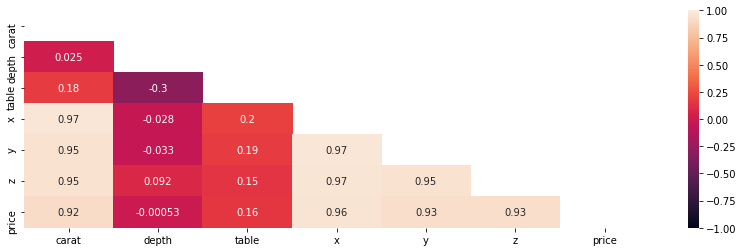

In [9]:
plt.figure(figsize=(14, 4))

mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))

sns.heatmap(data.corr(), vmin=-1, vmax=1, mask=mask, annot=True )

In [66]:
data = data.drop("depth", axis = 1)

In [67]:
test = test.drop("depth", axis = 1)

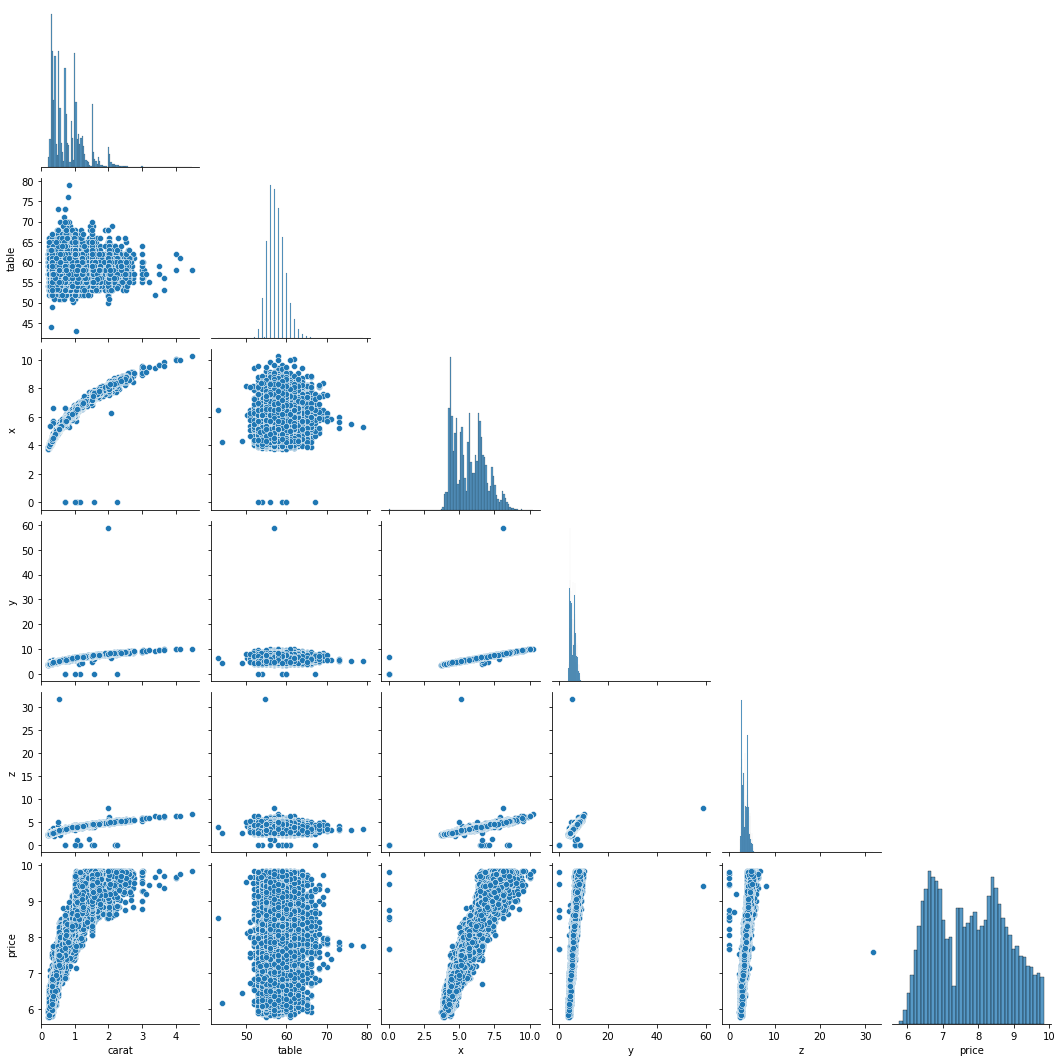

In [68]:
sns.pairplot(data, corner = True)

#### From this plot we can see, as the correlation matrix showed, that depth and table have no correlation with price. Also, it can be seen that in variables, x, y and z there are a few outliers, which we could delete

#### FInding outliers

In [11]:
def outliers(series):

    q3, q1 = np.percentile(series, [75 ,25])

    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)

    upper_bound = q3 + (1.5 * iqr)

    lista = []

    for i in series:

        if i > upper_bound or i < lower_bound:
            lista.append(i)

    return [len(lista),round(lower_bound,2), round(upper_bound,2)]
    

In [71]:
data = data.drop(data[(data.x < 1.98) & (data.y < 2.0) & (data.z <1.23) ].index)

In [74]:
data = data.drop(data[((data.y > 20) & data.z > 10)].index)

In [75]:
data = data.drop(data[data.carat > 2.5].index)

In [78]:
data = data.drop(data[(data.table < 50) & (data.table > 70)].index)

In [79]:
data.shape

(40338, 9)

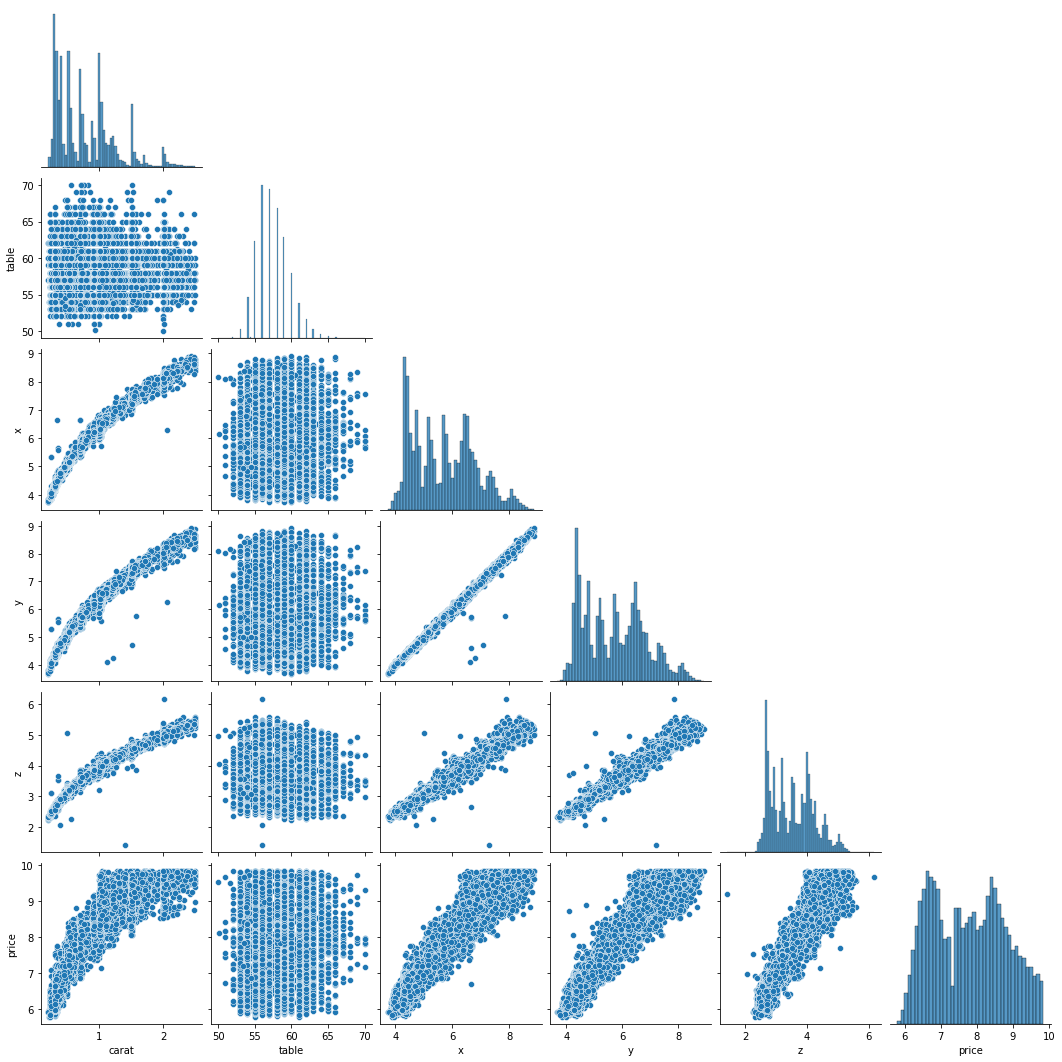

In [80]:
sns.pairplot(data, corner = True)

# We still have outliers, but the trends are more defined now

### Split between X variables and target variable

### Let's change our categorical values 

#### We can differentiate between two types of actegoricla variables:
    - Ordinal -> cut (order matters)
    - Nominal -> color and clarity (order doesn't matter)

In [81]:
# For the ordinal variable we have to use the OrdinalEncoder from the sklearn preprocessiong module

encoder = OrdinalEncoder()

data.cut = encoder.fit_transform(data.cut.values.reshape(-1, 1))

# Now, our values have changed to match a list beweten 0 and 4

In [82]:
test.cut = encoder.fit_transform(test.cut.values.reshape(-1, 1))

In [83]:
# For the nominal variables we can assign values ourselves

color_values = {'D': 10 , 'E': 9, 'F': 8, 'G': 7, 
              'H': 6, 'I': 5, 'J': 4, 'K': 3, 'L': 2, 'M': 1}

data["color_values"] = data.color.map(color_values)

In [84]:
clarity_values = {'I3': 1 , 'I2': 2, 'I1': 3, 'SI2': 4, 'SI1': 5, 'VS2': 6, 'VS1': 7, 
                  'VVS2': 8, 'VVS1': 9, 'IF': 10}

data["clarity_values"] = data.clarity.map(clarity_values)

In [85]:
data = data.drop(["clarity", "color"], axis = 1)

In [ ]:
test["clarity_values"] = test.clarity.map(clarity_values)
test["color_values"] = test.color.map(color_values)

test = test.drop(["clarity", "color"], axis = 1)

### Train-test split

#### For this project I'm going to split the data in 80% trainning and 20% testing

In [107]:
X =data.drop(["price"], axis = 1)
y = data.price

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=150)

### Model Evaluation

#### Basic Linear Regression

In [40]:
data.columns

Index(['carat', 'cut', 'table', 'x', 'y', 'z', 'price', 'color_values',
       'clarity_values'],
      dtype='object')

In [91]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred)

0.022041077057173918

In [98]:
pred = lr.predict(X_test)

In [102]:
y_test["price"] = pred

In [105]:
y_test.shape

(8069,)

In [106]:
pred.shape

(8068,)

In [108]:
mean_squared_error(y_test, pred)

0.022041077057173918

In [295]:
submission_1 = test["price"]

In [296]:
submission_1.to_csv("predictions\\submission_1")

### Second model

In [109]:
results = []

for depth in range(1,18):
    model = DecisionTreeRegressor(max_depth=depth, min_samples_split = 500)
    model.fit(X_train, y_train)
    
    result = {
        "depth": depth,
        "train_error": mean_squared_error(y_train, model.predict(X_train)),
        "test_error": mean_squared_error(y_test, model.predict(X_test))
    }
    
    results.append(result)

In [110]:
dt = DecisionTreeRegressor(max_depth=15)

dt.fit(X_train, y_train)

pred_tree = dt.predict(X_test)

In [111]:
mean_squared_error(y_test, pred_tree)

0.013809123818682231

In [113]:
pred_tree = dt.predict(X_test)

In [117]:
prueba = pd.DataFrame({"price":y_test,"linear_pred": lr.predict(X_test), "forest_pred": dt.predict(X_test)})
results = pd.DataFrame({"id":test.index,"linear_pred": lr.predict(test), "forest_pred": dt.predict(test)})
results["price"] = (results.linear_pred * 0.3 + results.forest_pred * 0.7)

In [118]:
mean_squared_error(y_test, pred_tree)

0.013809123818682231

In [141]:
submission_2 = results.drop(["linear_pred", "forest_pred"], axis =1)

In [142]:
submission_2.to_csv("predictions\\submission_3")

### Third Model

In [130]:
model = RandomForestRegressor()
parameter_space = {'n_estimators': [200, 250, 300],
                   'max_features': [0.3, 0.4],
                   'max_depth': [150, 200],
                   'min_samples_leaf': [1, 3, 5, 7]}

grid_search = GridSearchCV(model,
                           param_grid=parameter_space,
                           verbose=1,
                           n_jobs= None,
                           cv=5)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 26.3min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [150, 200], 'max_features': [0.3, 0.4],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'n_estimators': [200, 250, 300]},
             verbose=1)

In [133]:
best_est = grid_search.best_estimator_

In [137]:
best_est.fit(X_train, y_train)

RandomForestRegressor(max_depth=200, max_features=0.4, n_estimators=300)

In [138]:
y_pred = best_est.predict(X_test)

In [139]:
mean_squared_error(y_test, y_pred)

0.008113671891510577

In [145]:
pred = best_est.predict(test)

In [163]:
results = pd.DataFrame(pred)

In [164]:
results["id"] = test.index

In [166]:
results = results.set_index('id')

In [168]:
results.columns = ["price"]

In [170]:
results.to_csv("predictions\\submission_3")

### Fourth Model

In [174]:
model = GradientBoostingRegressor()
parameter_space = {'learning_rate': [0.1, 0.2, 0.3],
                   'max_features': [0.3, 0.4],
                   'max_depth': [150, 200],
                   'min_samples_leaf': [1, 3, 5, 7]}

grid_search = GridSearchCV(model,
                           param_grid=parameter_space,
                           verbose=1,
                           n_jobs= None,
                           cv=5)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 50.9min finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [150, 200], 'max_features': [0.3, 0.4],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [176]:
grid_search.best_score_

0.9919048396050473

In [177]:
best_est = grid_search.best_estimator_

In [178]:
best_est.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=150, max_features=0.4, min_samples_leaf=7)

In [187]:
pred = best_est.predict(X_test)

In [188]:
mean_squared_error(y_test, pred)

0.00808150866823083

In [189]:
pred = best_est.predict(test)

In [190]:
results = pd.DataFrame(pred)

In [192]:
results["id"] = test.index

In [194]:
results = results.set_index("id")

In [198]:
results.columns = ["price"]

In [200]:
results.to_csv("predictions\\submission_4")

### Conclusion and future improvements

From the four models developed, the best one has been the BoostingRegressor, with a mean_squared_error of 0.00801 in the y_test.

In order to improve the error I could have done more feature engineering, for example join x,y,z in just one variable (x*y*z) or I could have scaled the valuaes and trained a Kneighbor model. 

Also, I coudl have tried other options in the parametres used in the models in order to find a better fit.